In [1]:
import json
from dataclasses import dataclass

from google.cloud import vision
from google.oauth2 import service_account
from google.oauth2.service_account import Credentials as Credentials

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import japanize_matplotlib
from PIL import Image
import numpy as np


<class 'proto.marshal.collections.repeated.RepeatedComposite'>
紹介状不要
転送
患者氏名(カタカナ)
年 __________8
生年月日
年
従来の紹介状は不要です
① 妊娠週数
② アレルギー
③ 既往歴
□なし
④ 身長 / 体重
⑤ 最終食事時間
⑥ 発生時刻
⑦ 発生症例
⑧ 静脈ルート
母体搬送チェックシート
紹介元施設
⑨ 最終バイタル
脈拍:
血圧:
SpO2 :
⑩ CTG モニター □無
iPicss 撮影
① iPicss で撮影後、 送信
月
週
□無 □有(
□腹部手術既往 □凝固異常 □HIV HCVHBV感染有
□循環器疾患 □その他 (
cm /
(旧姓)
□有
8
日 □初産□経産
月
月
8
□ 常位胎盤早期剥離
□ 臍帯脱出
□ 子癇発作 (HELLP 症候群)
□ 呼吸困難, 意識消失
□胎児胎盤機能不全
□ 交通外傷
□ 子宮外妊娠破裂
□ その他 (
□無 □有
A
歳
0
kg → 歯のグラつき □無 □有
時
分頃
時
分頃
(左):
末梢ルート
末梢ルート (右):
%(
L)
G
G
¡Picss
ABO
蘇生 A B C
Ver.4.2
Airway 気道確保
Breathing 酸素投与 10L
| Circulation ルート確保
vertices {
  x: 20
  y: 12
}
vertices {
  x: 728
  y: 12
}
vertices {
  x: 728
  y: 1035
}
vertices {
  x: 20
  y: 1035
}

紹介
vertices {
  x: 38
  y: 25
}
vertices {
  x: 77
  y: 25
}
vertices {
  x: 77
  y: 43
}
vertices {
  x: 38
  y: 43
}

状
vertices {
  x: 79
  y: 25
}
vertices {
  x: 98
  y: 25
}
vertices {
  x: 98
  y: 43
}
vertices {
  x: 79
  y: 43
}

不要
vertices {
  x: 99
  y: 25
}
vertices {
  x: 138


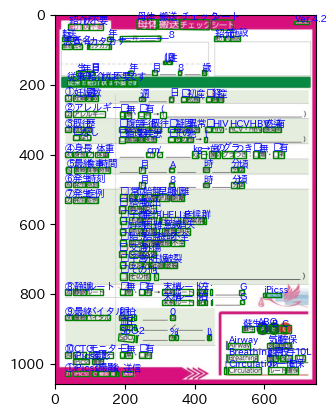

In [2]:

@dataclass
class ConfigJSON:
    type: str
    project_id: str
    private_key_id: str
    private_key: str
    client_email: str
    client_id: str
    auth_uri: str
    token_uri: str
    auth_provider_x509_cert_url: str
    client_x509_cert_url: str
    universe_domain: str


def oauth(json_file_path: str) -> Credentials:
    return service_account.Credentials.from_service_account_file(json_file_path)


def get_image(img_path: str) -> bytes:
    with open(img_path, "rb") as file:
        return file.read()
    

def draw_texts(img_path: str, texts) -> None:
    # Open image file
    im = np.array(Image.open(img_path), dtype=np.uint8)

    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(im)

    # Create a Rectangle patch and text for each detected text
    for text in texts[1:]: #texts[0] is the whole image
        vertices = [(vertex.x, vertex.y) for vertex in text.bounding_poly.vertices]
        rect = patches.Polygon(vertices, linewidth=1, edgecolor='green', facecolor='none')
        ax.add_patch(rect)
        ax.text(vertices[0][0], vertices[0][1], text.description, fontsize=7, color='blue')

    # Show the plot with detected texts
    plt.show()


def detect_text(img_path: str) -> None:

    credential = oauth("../baito-ocr-sample-ccb6bb9f060c.json")

    client = vision.ImageAnnotatorClient(credentials=credential)
    image = vision.Image(content=get_image(img_path))

    response = client.text_detection(image=image)

    texts = response.text_annotations
    print(type(texts))

    #結果を横に並べて表示
    for text in texts:
        print(text.description)
        print(text.bounding_poly)
    # <class 'proto.marshal.collections.repeated.RepeatedComposite'>
    draw_texts(img_path, texts)


    
    

if __name__ == "__main__":
    detect_text("../sheet1.jpg")


In [1]:
#openCVによるチェックマークの認識テスト

import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

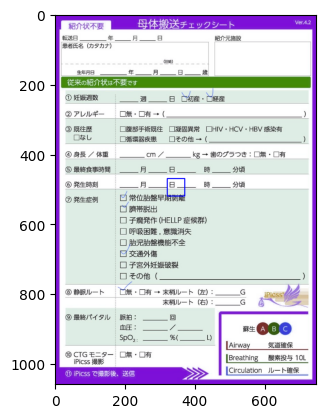

In [21]:
#画像の読み込み
base_img = cv2.imread("../sheet1.jpg")
mark_img = cv2.imread("../checkmark.png")
#グレースケール化
base_gray = cv2.cvtColor(base_img, cv2.COLOR_BGR2GRAY)
mark_gray = cv2.cvtColor(mark_img, cv2.COLOR_BGR2GRAY)
#マッチングテンプレート
result = cv2.matchTemplate(base_gray, mark_gray, cv2.TM_CCOEFF_NORMED)
#検出結果から検出領域の位置を取得
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
top_left = max_loc
bottom_right = (top_left[0] + 50, top_left[1] + 50)
#検出領域を四角で囲んでplot表示
result_img = cv2.imread("../sheet1.jpg")
cv2.rectangle(result_img, top_left, bottom_right, (0, 0, 255), 2)
plt.imshow(result_img)


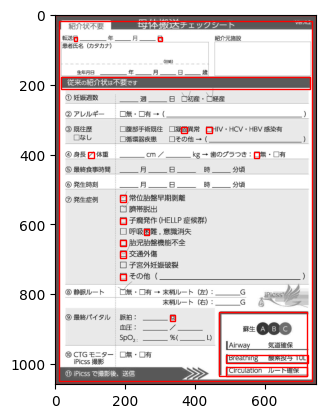

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def detect_checkboxes(image_path):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Perform binary thresholding on the image to make it black and white
    _, image_bin = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)

    # Find contours in the binary image
    contours, _ = cv2.findContours(image_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on their shape (rectangle) and size
    checkboxes = []
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 0.01*cv2.arcLength(contour, True), True)
        x, y, w, h = cv2.boundingRect(approx)
        if len(approx) == 4 and w * h > 100:  # Change this value based on the size of the checkboxes
            checkboxes.append((x, y, w, h))

    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image, cmap='gray')

    # Draw rectangles around the detected checkboxes
    for x, y, w, h in checkboxes:
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # Show the plot with the detected checkboxes
    plt.show()

# Call the function with your image path
detect_checkboxes('../sheet1.jpg')
